# PART 1: Data Pre-Processing and Autoencoders for Dimensionality Reduction

## Downloading the Data

In this first block of code we will be downloading the data from the Kaggle challenge into our Google drive folder. We do this by 1) mounting the notebook to our Google Drive, 2) accessing the relevant folder within the Drive, and 3) downloading the data from Kaggle using our unique Kaggle API

In order to download the data from Kaggle, you need to download the API token unique to your account (the kaggle.json file). You can do this by going to “My Account” in Kaggle, scrolling down to “API” and clicking on “Create New API Token.” This will automatically download a kaggle.json file to your computer.

Additionally, you will also need to accept the competition rules of the challenge. You do this by going to the challenge page on Kaggle, clicking on “Join Competition,” and then “I Understand and Accept” to agree to being bound by the competition rules.

In [0]:
# connecting notebook to google drive
# click on the URL, give permissions and copy and paste the authorisation code to connect
from google.colab import drive
drive.mount('/gdrive')

# access the relevant folder in the Google Drive to download the data in
import os
os.chdir('/gdrive/My Drive/Cactus')

# downloading the data from Kaggle
# make sure you have the right Kaggle library installed
!pip3 install kaggle==1.5.6
!kaggle -v

# make a .kaggle folder in your drive 
!mkdir .kaggle
# save kaggle.json file with your username and unique key in .kaggle
!echo '{"username":"USERNAME","key":"UNIQUE_KEY"}' > /root/.kaggle/kaggle.json
# change the file permissions so you can read and write from this file (but not execute)
!chmod 600 /root/.kaggle/kaggle.json

# get data from https://www.kaggle.com/c/aerial-cactus-identification/
!kaggle competitions download -c aerial-cactus-identification

# unzip data
!unzip train.zip
!unzip test.zip

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


## Importing Libraries

Below are the libraries needed for data pre-processing and an autoencoder with Keras and a TensorFlow backend.

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
import imageio
import cv2
from sklearn.model_selection import train_test_split

%tensorflow_version 1.x

import keras
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model, load_model

TensorFlow 1.x selected.


Using TensorFlow backend.


## Data Pre-Processing

In this section we load the data, sort the labels to match the order of the images they classify, pre-process the image data, split the data into training, validation and testing sets, and save all our pre-processed data

In [0]:
# importing the training label data
train_label = pd.read_csv('train.csv')

# viewing the first 5 lines of the data
train_label.head()

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


When we import our images, they will not necessarily be in the same order as the `train_label` dataframe. Therefore, we use the following code to create a new dataframe based on the order of the image filenames from our training data folder, and we save this csv.

In [0]:
# accessing the folder with the training data
os.chdir('/gdrive/My Drive/Cactus/train')
# list of filenames in the order images will be imported
filenames = glob.glob('*.*')

# list of dummy data the length of our filenames for new sorted labels
sorted_cactus = ["a"]*len(filenames)

# loop to search for the id in the filenames and train_label
# and assign the right classification in the right order to the new list
for i in range(len(filenames)):
  for j in range(len(train_label)):
    if filenames[i] == train_label["id"][j]:
      sorted_cactus[i] = train_label["has_cactus"][j]

# create new dataframe of sorted labels
d = {'id': filenames, 'has_cactus': sorted_cactus}
labels_sort = pd.DataFrame(data=d)

# accessing the main folder to save the csv
os.chdir('/gdrive/My Drive/Cactus')
# save dataframe as csv to folder
labels_sort.to_csv("train_label_sorted.csv")

In [0]:
labels_sort.head()

,id,has_cactus
0,f16725de59ce7fb77394a53f7fabca1d.jpg,1
1,f13f85ff50e2050c17a29f0cb235159d.jpg,0
2,f0b87bc1d72ebb1ed24c492b3e93b9c1.jpg,1
3,f13c2f38353668279f4fb0bfd745a69e.jpg,1
4,f168e2001e464afff52e799b93535196.jpg,1


We use the following code to import and pre-process our image data, ensuring that all our images are the same size (32 x 32 x 3, since we are working with colour images) and appending each image array to our training list.

In [0]:
# standardised image size
IMAGE_SIZE = (32, 32)

# list we will save our image arrays to
train_img = []

# loop to resize and reshape the RGB images into arrays
for index, filename in enumerate(glob.glob('train/*.*')):
  # read the image files
  image = imageio.imread(filename)
  # resize the data for standardisation
  image = cv2.resize(image, IMAGE_SIZE)
  # convert the image data to an array
  image = np.array(image)
  # append the image array to our list
  train_img.append(image)

In [0]:
print(len(train_img))

17500


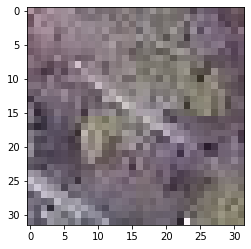

In [0]:
plt.imshow(train_img[150])

We then run the following code to format our data so that it can be used in our model :

* turning the list into an array,
* making sure that all the data is of the same type, float32 and standardised,
* ensuring our array is the right shape, and
* splitting our image and label data into a train, validation and test set so that we can measure the generalisability of our model to unseen data.

In [0]:
# creating an array of our image data
train_data = np.array(train_img)

# standardising our image data
train_data = train_data.astype('float32') / 255.

# ensuring our images are the right shape
train_data = train_data.reshape(len(train_data), 32, 32, 3)

# splitting our data into a training, validation, and testing set
train_data, eval_data, train_label, eval_label = train_test_split(train_data, labels_sort, random_state=42)
eval_data, test_data, eval_label, test_label = train_test_split(eval_data, eval_label, test_size=0.5, random_state=42)

Lastly, since 17500 images can take a substantial amount of time to load into our notebook, we save the numpy arrays into our folder, so that if we return to the code later, we can just import these pre-processed arrays quickly, instead of rerunning all the above code. We do this with the `np.save()` function, and the `np.load()` function of npy file types.

In [0]:
# saving our original dataset and training, validation, and testing numpy arrays
np.save("train_img", train_img)
np.save("train_data", train_data)
np.save("eval_data", eval_data)
np.save("test_data", test_data)

np.save("train_label", train_label)
np.save("eval_label", eval_label)
np.save("test_label", test_label)

# loading all our arrays
train_img = np.load("train_img.npy")
train_data = np.load("train_data.npy")
eval_data = np.load("eval_data.npy")
test_data = np.load("test_data.npy")

train_label = np.load("train_label.npy")
eval_label = np.load("eval_label.npy")
test_label = np.load("test_label.npy")

## Autoencoders

The final section of Part 1 is building the autoencoder. There are two versions of the autoencoder, with the second improving on the first. We also use some data visualisations to measure the performance of our autoencoders.

### Autoencoder 1 (8 layers)

This was the first autoencoder tested, but it did not capture enough of the original image information. Therefore, in the second autoencoder below, there are two less layers (one less in the encoder and one less in the decoder) to increase the information held within the bottleneck. In this way, the dimensionalities are reduced less in the final autoencoder, but the decoder is able to better reconstruct the original images.

The code below shows the full architecture of our autoencoder using a neural network where we have three layers each for the encoder and the decoder.

As you can see, we use a binary cross-entropy loss function. This type of loss function is used when our output is a probability between 0 and 1 (in this case how probable is that our reconstruction looks like our original image), and, we can expect our cross-entropy loss to increase when our reconstruction diverges from the original image.

Additionally, we compile our autoencoder with an optimiser (`adadelta`) which both updates our model parameters in order to minimise our loss between iterations, and defines at what rate (the learning rate) our model parameters update between iterations.

In [0]:
# this is our input placeholder
input_img = Input(shape=(32, 32, 3))  

## ENCODER ##
# Conv1 #
encoded = Conv2D(filters = 256, kernel_size = (3, 3), activation='relu', padding='same')(input_img)
encoded = Conv2D(filters = 256, kernel_size = (3, 3), activation='relu', padding='same')(encoded)
encoded = MaxPooling2D(pool_size = (2, 2), padding='same', strides=2)(encoded)
print(encoded.shape)

# Conv2 #
encoded = Conv2D(filters = 128, kernel_size = (3, 3), activation='relu', padding='same')(encoded)
encoded = Conv2D(filters = 128, kernel_size = (3, 3), activation='relu', padding='same')(encoded)
encoded = MaxPooling2D(pool_size = (2, 2), padding='same', strides=2)(encoded)
print(encoded.shape)

# Conv3 #
encoded = Conv2D(filters = 64, kernel_size = (3, 3), activation='relu', padding='same')(encoded)
encoded = Conv2D(filters = 64, kernel_size = (3, 3), activation='relu', padding='same')(encoded)
encoded = MaxPooling2D(pool_size = (2, 2), padding='same', strides=2)(encoded)
print(encoded.shape)

# Conv4 #
encoded = Conv2D(filters = 32, kernel_size = (3, 3), activation='relu', padding='same')(encoded)
encoded = Conv2D(filters = 32, kernel_size = (3, 3), activation='relu', padding='same')(encoded)
encoded = MaxPooling2D(pool_size = (2, 2), padding='same', strides=2)(encoded)
print(encoded.shape)


## DECODER ##

# DeConv1
decoded = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
decoded = Conv2D(32, (3, 3), activation='relu', padding='same')(decoded)
decoded = UpSampling2D((2, 2))(decoded)
print(decoded.shape)

# DeConv2
decoded = Conv2D(64, (3, 3), activation='relu', padding='same')(decoded)
decoded = Conv2D(64, (3, 3), activation='relu', padding='same')(decoded)
decoded = UpSampling2D((2, 2))(decoded)
print(decoded.shape)

# DeConv3
decoded = Conv2D(128, (3, 3), activation='relu', padding='same')(decoded)
decoded = Conv2D(128, (3, 3), activation='relu', padding='same')(decoded)
decoded = UpSampling2D((2, 2))(decoded)
print(decoded.shape)

# DeConv4
decoded = Conv2D(256, (3, 3), activation='relu', padding='same')(decoded)
decoded = Conv2D(256, (3, 3), activation='relu', padding='same')(decoded)
decoded = UpSampling2D((2, 2))(decoded)
print(decoded.shape)

decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(decoded)
print(decoded.shape)


## ENCODER and AUTOENCODER ##

autoencoder = Model(input_img, decoded)
encoder = Model(input_img, encoded)

autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')


Instructions for updating:
If using Keras pass *_constraint arguments to layers.

(?, 16, 16, 256)
(?, 8, 8, 128)
(?, 4, 4, 64)
(?, 2, 2, 32)
(?, 4, 4, 32)
(?, 8, 8, 64)
(?, 16, 16, 128)
(?, 32, 32, 256)
(?, 32, 32, 3)
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


We then fit this autoencoder to our training data. We have set the number of iterations (`epochs`) to 1000, and the batch size (the number of training examples used per iteration) to 256.

In [0]:
# fitting the training data to the autoencoder model
 autoencoder.fit(train_data, train_data,
                 epochs=1000,
                 batch_size=256,
                 shuffle=True,
                 validation_data=(eval_data, eval_data))

We can save our model for future use, using the Keras `save` and `load_model` functions:

In [0]:
# saving whole model
autoencoder.save('autoencoders/autoencoder_model1.h5')

# saving encoder for dimensionality reduction
encoder.save('autoencoders/encoder_model1.h5')
 
# loading whole model
model1 = load_model('autoencoders/autoencoder_model1.h5')

The importance of creating a full encoder, even though we will only use the encoder to reduce the dimensionality of our images for the classification problem, is that we want to know how successful our autoencoder is at capturing the most important attributes.

To measure whether our autoencoder is improving over the iterations, we can plot a function that shows how our loss changes over time for the training set and the validation set. The lower the loss, the less the difference between our original images and our reconstructed images, and therefore the better our model.

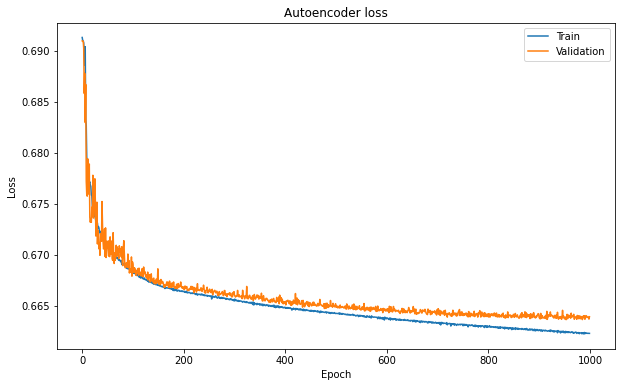

In [0]:
plt.figure(figsize=(10, 6))
# history.history stores the training and validation loss of our model when fitting
plt.plot(autoencoder.history.history['loss'])
plt.plot(autoencoder.history.history['val_loss'])
plt.title('Autoencoder loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

Additionally, we can use the validation set to reconstruct some of the images through our autoencoder and compare them to the original images to manually analyse how well our autoencoder works.

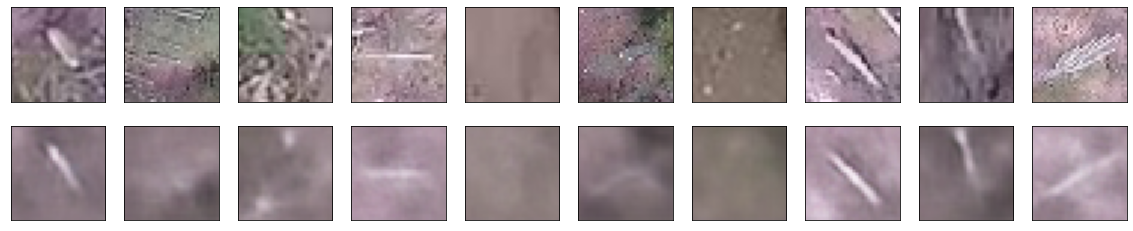

In [0]:
# reconstructed images from validation set
reconst_test = autoencoder.predict(eval_data)

# number of images
n = 10
# number of rows in plot
row = 2

plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(row, n, i + 1)
    plt.imshow(eval_data[i].reshape(32, 32, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(row, n, i + 1 + n)
    plt.imshow(reconst_test[i].reshape(32, 32, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

### Autoencoder 2 (6 layers)

Here we repeat the above implementation, but reduce the amount of layers in our autoencoder to make our bottleneck larger and increase the amount of information kept by the model.

In [0]:
# input layer
input_img_2 = Input(shape=(32, 32, 3))  

## ENCODER ##
# Conv1 #
encoded_2 = Conv2D(filters = 256, kernel_size = (3, 3), activation='relu', padding='same')(input_img_2)
encoded_2 = Conv2D(filters = 256, kernel_size = (3, 3), activation='relu', padding='same')(encoded_2)
encoded_2 = MaxPooling2D(pool_size = (2, 2), padding='same', strides=2)(encoded_2)
print(encoded_2.shape)

# Conv2 #
encoded_2 = Conv2D(filters = 128, kernel_size = (3, 3), activation='relu', padding='same')(encoded_2)
encoded_2 = Conv2D(filters = 128, kernel_size = (3, 3), activation='relu', padding='same')(encoded_2)
encoded_2 = MaxPooling2D(pool_size = (2, 2), padding='same', strides=2)(encoded_2)
print(encoded_2.shape)

# Conv3 #
encoded_2 = Conv2D(filters = 64, kernel_size = (3, 3), activation='relu', padding='same')(encoded_2)
encoded_2 = Conv2D(filters = 64, kernel_size = (3, 3), activation='relu', padding='same')(encoded_2)
encoded_2 = MaxPooling2D(pool_size = (2, 2), padding='same', strides=2)(encoded_2)
print(encoded_2.shape)

## DECODER ##

# DeConv1
decoded_2 = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded_2)
decoded_2 = Conv2D(64, (3, 3), activation='relu', padding='same')(decoded_2)
decoded_2 = UpSampling2D((2, 2))(decoded_2)
print(decoded_2.shape)

# DeConv2
decoded_2 = Conv2D(128, (3, 3), activation='relu', padding='same')(decoded_2)
decoded_2 = Conv2D(128, (3, 3), activation='relu', padding='same')(decoded_2)
decoded_2 = UpSampling2D((2, 2))(decoded_2)
print(decoded_2.shape)

# DeConv3
decoded_2 = Conv2D(256, (3, 3), activation='relu', padding='same')(decoded_2)
decoded_2 = Conv2D(256, (3, 3), activation='relu', padding='same')(decoded_2)
decoded_2 = UpSampling2D((2, 2))(decoded_2)
print(decoded_2.shape)

decoded_2 = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(decoded_2)
print(decoded_2.shape)


## ENCODER and AUTOENCODER ##

autoencoder_2 = Model(input_img_2, decoded_2)
encoder_2 = Model(input_img_2, encoded_2)

autoencoder_2.compile(optimizer='adadelta', loss='binary_crossentropy')


(?, 16, 16, 256)
(?, 8, 8, 128)
(?, 4, 4, 64)
(?, 8, 8, 64)
(?, 16, 16, 128)
(?, 32, 32, 256)
(?, 32, 32, 3)


In [0]:
# fitting the training data to the autoencoder model
 autoencoder_2.fit(train_data, train_data,
                 epochs=1000,
                 batch_size=256,
                 shuffle=True,
                 validation_data=(eval_data, eval_data))

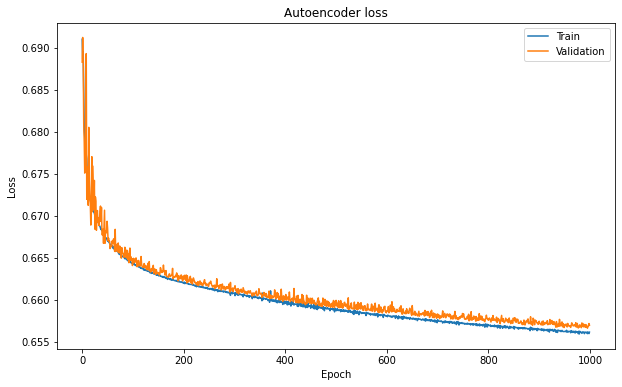

In [0]:
plt.figure(figsize=(10, 6))
# history.history stores the training and validation loss of our model when fitting
plt.plot(autoencoder_2.history.history['loss'])
plt.plot(autoencoder_2.history.history['val_loss'])
plt.title('Autoencoder loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

As we can see from the plot above, the loss gets reduced to 0.6562 for our training data, and around 0.6570 for our validation set. We can tell by this plot that our autoencoder is not overfitting too much, as the validation loss (the loss calculated on unseen data) reduces during training. It also seems as though the validation loss is still reducing, but at a much slower rate by 1000 epochs, therefore with more iterations, our model could improve. However, since it can take many hours, even days, to train this model for 1000s of epochs on Google Colab’s free GPU, for the purpose of this tutorial, we will stop at 1000 iterations.

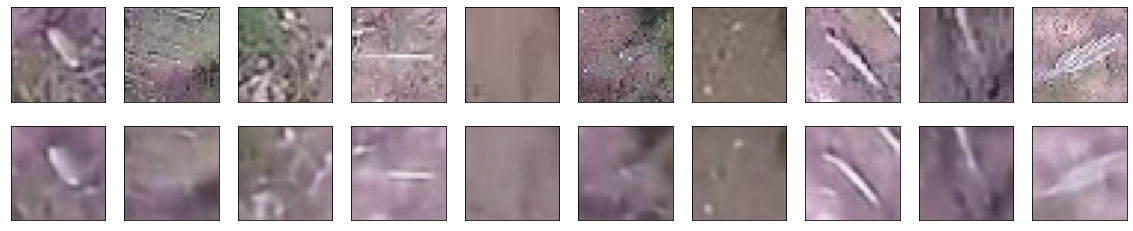

In [0]:
# reconstructed images from validation set
reconst_test_2 = autoencoder_2.predict(eval_data)

# number of images
n = 10
# number of rows in plot
row = 2

plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(row, n, i + 1)
    plt.imshow(eval_data[i].reshape(32, 32, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(row, n, i + 1 + n)
    plt.imshow(reconst_test_2[i].reshape(32, 32, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

As we can see, the autoencoder is unable to capture all the details of the original images in its reconstruction. However, it does reconstruct the more major visual differences, such as contrasted shapes in some of the images, and the general colour differences in the images.

In [0]:
autoencoder_2.save('autoencoders/autoencoder_model2.h5')
encoder_2.save('autoencoders/encoder_model2.h5')

# PART 2: Principle Component Analysis (PCA)

In [0]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [0]:
pca_x = np.reshape(train_data, (420000,96))

In [0]:
scaler = StandardScaler()
scaler.fit(pca_x)
scaled_x = scaler.transform(pca_x)

In [0]:
pca = PCA(.95)

pca_transformed = pca.fit_transform(scaled_x)

In [0]:
pca_transformed.shape

(420000, 25)

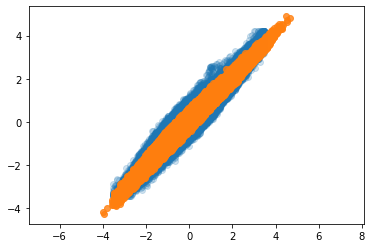

In [0]:
inv = pca.inverse_transform(pca_transformed)

plt.scatter(scaled_x[:, 0], scaled_x[:, 1], alpha=0.2)
plt.scatter(inv[:, 0], inv[:, 1], alpha=0.8)
plt.axis('equal');

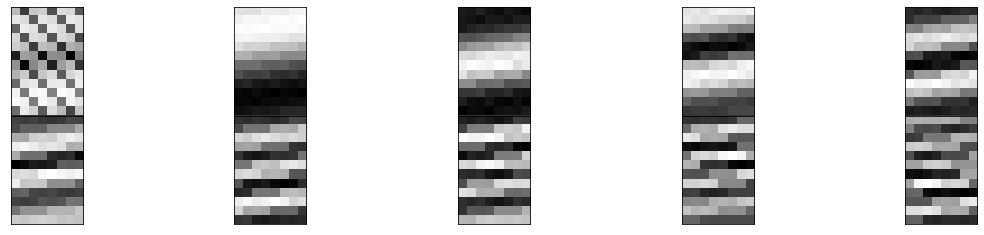

In [0]:
fig, axes = plt.subplots(2,5,figsize=(20,4),
 subplot_kw={'xticks':[], 'yticks':[]},
 gridspec_kw=dict(hspace=0.01, wspace=0.01))
for i, ax in enumerate(axes.flat):
    ax.imshow(pca.components_[i].reshape(12,8), cmap='gray')

In [0]:
pca.explained_variance_ratio_

array([0.49112291, 0.06828804, 0.05008554, 0.03785753, 0.03250195,
       0.02809322, 0.02465911, 0.02309006, 0.02074755, 0.01924318,
       0.01730684, 0.01653729, 0.01480574, 0.01385143, 0.01242872,
       0.01181671, 0.01117544, 0.01004744, 0.00921224, 0.0084142 ,
       0.00788549, 0.00707361, 0.00655153, 0.00610805, 0.00576967])

In [0]:
pca2 = PCA(10)

pca_transformed2 = pca2.fit_transform(scaled_x)

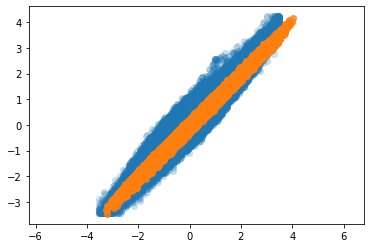

In [0]:
inv2 = pca2.inverse_transform(pca_transformed2)

plt.scatter(scaled_x[:, 0], scaled_x[:, 1], alpha=0.2)
plt.scatter(inv2[:, 0], inv2[:, 1], alpha=0.8)
plt.axis('equal');

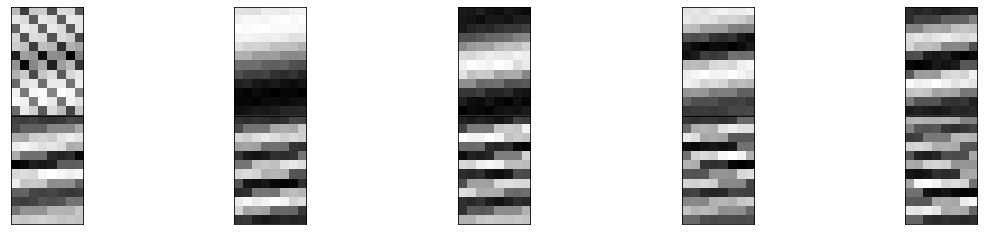

In [0]:
fig, axes = plt.subplots(2,5,figsize=(20,4),
 subplot_kw={'xticks':[], 'yticks':[]},
 gridspec_kw=dict(hspace=0.01, wspace=0.01))
for i, ax in enumerate(axes.flat):
    ax.imshow(pca2.components_[i].reshape(12,8), cmap='gray')

In [0]:
pca2.explained_variance_ratio_

array([0.49119643, 0.06829833, 0.05009302, 0.03786306, 0.03250632,
       0.02809714, 0.02466034, 0.02308297, 0.02074665, 0.01921887])

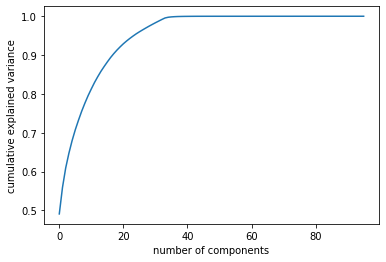

In [0]:
pca = PCA().fit(scaled_x)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

# PART 3: Model Selection and Implementation with CNNs

In this part, the goal is to train a CNN on three different data. First, there is encoded data produced by the validated autoencoder above. Then there are images produced by PCA. Finally, there are original images, but a different network.  

## Trying a model on the encoded data and the PCA

In [0]:
def cnn_model(input_img):
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    print (x.shape)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    print (x.shape)
    x = MaxPool2D((2, 2), padding='same')(x)
    print (x.shape)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    print (x.shape)
    x = MaxPool2D((2, 2), padding='same')(x)
    print (x.shape)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    print (x.shape)
    x = MaxPool2D((2, 2), padding='same')(x)
    print (x.shape)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    print (x.shape)
    x = MaxPool2D((2, 2), padding='same')(x)
    print (x.shape)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    print (x.shape)
    x = MaxPool2D((2, 2), padding='same')(x)
    print (x.shape)
    x = Flatten()(x)
    x = Dense(512, activation = 'relu')(x)
    print (x.shape)
    x = Dense(1, activation = 'sigmoid')(x)
    print (x.shape)
    return x

Loading the encoded data

In [0]:
img_lbl = train_label['has_cactus'].values
img_enc = np.load('train_img_enc.npy')

Splitting encoded data into a training, validation, and testing set

In [0]:
train_data_enc, eval_data_enc, train_label_enc, eval_label_enc = train_test_split(img_enc, img_lbl, random_state=42)
eval_data_enc, test_data_enc, eval_label_enc, test_label_enc = train_test_split(eval_data_enc, eval_label_enc, test_size=0.5, random_state=42)

Splitting PCA data into a training, validation, and testing set

In [0]:
train_data_pca, eval_data_pca, train_label_pca, eval_label_pca = train_test_split(pca_transformed, img_lbl, random_state=42)
eval_data_pca, test_data_pca, eval_label_pca, test_label_pca = train_test_split(eval_data_pca, eval_label_pca, test_size=0.5, random_state=42)

Defining the model

In [0]:
def define_model(input_img):
    x = cnn_model(input_img)
    model = Model(input_img, x)
    return model

In [0]:
num_epochs = 100 
batch_size = 200

Training rthe model

In [0]:
def train_model(model, train_x, train_y, val_x, val_y):
    model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])
    with tf.device(tf.DeviceSpec(device_type="GPU", device_index=0)):
        model.fit(train_x, train_y,                    
                        epochs=num_epochs, 
                        batch_size=batch_size, 
                        shuffle=True, 
                        validation_data=(val_x, val_y))
    return model

In [0]:
def full_train(inp_shape, train_x, train_y, test_x, val_x, val_y):
    input_img = Input(shape = inp_shape)
    model = define_model(input_img)
    model_trained = train_model(model, train_x, train_y, val_x, val_y)
    predictions = model_trained.predict(test_x)
    return model_trained, predictions

### Training on the encoded data

In [0]:
model_trained_enc, predictions_enc = full_train((4, 4, 64), train_data_enc, train_label_enc, test_data_enc, eval_data_enc, eval_label_enc)

### Training on the PCA data

In [0]:
inp_shape_pca = pca_transformed.shape
model_trained_pca, predictions_pca = full_train(inp_shape_pca, train_data_pca, train_label_pca, test_data_pca, eval_data_enc, eval_label_enc)

## Autoencoder-Inspired CNN

Adding the FC layer to the encoder part

In [0]:
def fully_connected(encoded):
    flaten_layer = Flatten()(encoded)
    fc_layer_1= Dense(128, activation='relu')(flaten_layer)
    fc_layer_2= Dense(2, activation='softmax')(fc_layer_1)
    return fc_layer_2

In [0]:
input_img = Input(shape = (32, 32, 3))
encoded = encode(input_img)
cnn_model= Model(input_img, fully_connected(encode))

Getting the weights from th trained AE and setting the to untrainable, so we only train the classifiier

In [0]:
for l1, l2in zip(cnn_model.layers[:10], encoded_model.layers[0:10]):
    l1.set_weights(l2.get_weights())
    l1.trainable = False

In [0]:
train_img_lbl_binary = keras.utils.to_categorical(train_img_lbl)

In [0]:
cnn_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])

Trainig the model

In [0]:
cnn_model.fit(train_data, train_label, batch_size=500,
epochs=10,
verbose=1)

In [0]:
predicts = cnn_model.predict(test_data)
predicted_classes = np.argmax(np.round(predicts),axis=1)

Plotting the loss graph

In [ ]:
acc= cnn_model.history['loss']  ##getting  accuracy of each epochs
epochs_=range(0,10)    
plt.plot(epochs_, acc,label='training loss')
plt.xlabel('no of epochs')
plt.ylabel('loss')

acc_val=cnn_model.history['val_loss']  ##getting validation accuracy of each epochs
plt.scatter(epochs_,acc_val,label="validation loss")
plt.title("no of epochs vs loss")
plt.legend()


In [ ]:
print("Training metrics for the AE classification:")
print(sklearn.metrics.classification_report(y_true= y_test, y_pred= predicted_classes))

## Random model - SVM

In [ ]:
def rgb2gray(img):
    return np.dot(img[...,:3], [0.2989, 0.5870, 0.1140])

Getting the grayscale data 

In [ ]:
X_train_grayscale = []
for i in range(len(X_train)):
    print (i)
    X_train_grayscale = np.append(X_train_grayscale, rgb2gray(X_train[i]))

Training an SVM and plotting the classification report 

In [ ]:
from sklearn import svm

svm_cl = svm.SVC()
svm_cl.fit(X_train_grayscale_shaped, y_train)
X_test_grayscale_scaled = X_test_grayscale.reshape(len(X_test), 32*32)
y_pred_test = svm_cl.predict(X_test_grayscale_scaled)

print("Training metrics:")
print(sklearn.metrics.classification_report(y_true= y_train, y_pred= y_test))
